# 数据来源

数据来自美国的加利福尼亚州的洛杉矶市，第一个CSV文件是关于节点的表示情况，一共有307个节点，第二个npz文件是交通流量的文件，时间范围是两个月（2018.1.1——2018.2.28），每5分钟测一次。

搭建网络框架需要四步：

（１）准备数据

（２）定义模型（模型的定义，以及输入、隐藏、输出层数）

（３）定义损失函数和优化器

（４）训练+测试（把数据灌入里面）

# 数据分析

['data']
(16992, 307, 3)
(16992, 307, 3)


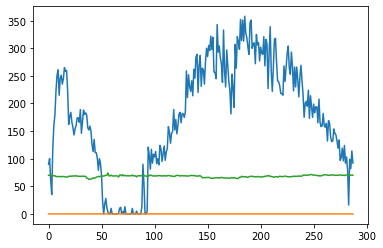

In [1]:
# 在处理数据之前，先看看拿到的数据长什么样子，我们可视化数据看看
import numpy as np
import matplotlib.pyplot as plt

def get_flow(file_name): # 将读取文件写成一个函数
   
    flow_data = np.load(file_name) # 载入交通流量数据
    print([key for key in flow_data.keys()]) # 打印看看key是什么
    
    print(flow_data["data"].shape)  # (16992, 307, 3)，16992是时间(59*24*12)，307是节点数，3表示每一维特征的维度（类似于二维的列）
    flow_data = flow_data['data'] # [T, N, D]，T为时间，N为节点数，D为节点特征

    return flow_data

# 做工程、项目等第一步对拿来的数据进行可视化的直观分析
if __name__ == "__main__":

    traffic_data = get_flow(r"D:\办公文件\编程\深度学习\PeMS_04\PeMS04.npz")
    node_id = 10
    print(traffic_data.shape)
    
    plt.plot(traffic_data[:24*12, node_id, 0])  # 0维特征
    plt.savefig("node_{:3d}_1.png".format(node_id))

    plt.plot(traffic_data[:24 * 12, node_id, 1])  # 1维特征
    plt.savefig("node_{:3d}_2.png".format(node_id))

    plt.plot(traffic_data[:24 * 12, node_id, 2])  # 2维特征
    plt.savefig("node_{:3d}_3.png".format(node_id))

所以可得出：每个节点有三个特征，但是其他两个节点基本是平稳不变的，所以我们只取第一维特征。

# 数据处理

In [69]:
# 1 读入数据并取需要的特征
import csv
import torch
import numpy as np
from torch.utils.data import Dataset

def get_flow(file_name):

    flow_data = np.load(file_name)
    print([key for key in flow_data.keys()])
    print(flow_data["data"].shape)  # (16992, 307, 3)，16992是时间(59*24*12)，307是节点数，3表示每一维特征的维度（类似于二维的列）
    
    flow_data = flow_data['data'].transpose([1, 0, 2])[:, :, 0][:, :, np.newaxis]  # [N, T, D],transpose就是转置，让节点纬度在第0位，N为节点数，T为时间，D为节点特征
    # 对np.newaxis说一下，就是增加一个维度，这是因为一般特征比一个多，即使是一个，保持这样的习惯，便于通用的处理问题

    return flow_data

只取第一维特征，并且为了后面方便，将节点的维度放在第一维，所以重写的get_flow()函数如下：

In [70]:
# 2 数据集处理：写成PyTorch所需要的数据集的类
# 2.1 读入邻接矩阵
def get_adjacent_matrix(distance_file: str, num_nodes: int, id_file: str = None, graph_type="connect") -> np.array:
    """
    :param distance_file: str, path of csv file to save the distances between nodes.
    :param num_nodes: int, number of nodes in the graph
    :param id_file: str, path of txt file to save the order of the nodes.就是排序节点的绝对编号所用到的，这里排好了，不需要
    :param graph_type: str, ["connect", "distance"]，这个就是考不考虑节点之间的距离
    :return:
        np.array(N, N)
    """
    A = np.zeros([int(num_nodes), int(num_nodes)])  # 构造全0的邻接矩阵

    if id_file:  # 就是给节点排序的绝对文件，这里是None，则表示不需要
        with open(id_file, "r") as f_id: 
            # 将绝对编号用enumerate()函数打包成一个索引序列，然后用node_id这个绝对编号做key，用idx这个索引做value
            node_id_dict = {int(node_id): idx for idx, node_id in enumerate(f_id.read().strip().split("\n"))}

            with open(distance_file, "r") as f_d:
                f_d.readline() # 表头，跳过第一行.
                reader = csv.reader(f_d) # 读取.csv文件.
                for item in reader:   # 将一行给item组成列表
                    if len(item) != 3: # 长度应为3，不为3则数据有问题，跳过
                        continue
                    i, j, distance = int(item[0]), int(item[1]), float(item[2]) # 节点i，节点j，距离distance
                    if graph_type == "connect":  # 这个就是将两个节点的权重都设为1，也就相当于不要权重
                        A[node_id_dict[i], node_id_dict[j]] = 1.
                        A[node_id_dict[j], node_id_dict[i]] = 1.
                    elif graph_type == "distance":  # 这个是有权重，下面是权重计算方法
                        A[node_id_dict[i], node_id_dict[j]] = 1. / distance
                        A[node_id_dict[j], node_id_dict[i]] = 1. / distance
                    else:
                        raise ValueError("graph type is not correct (connect or distance)")
        return A

    with open(distance_file, "r") as f_d:
        f_d.readline()  # 表头，跳过第一行.
        reader = csv.reader(f_d)  # 读取.csv文件.
        for item in reader:  # 将一行给item组成列表
            if len(item) != 3: # 长度应为3，不为3则数据有问题，跳过
                continue
            i, j, distance = int(item[0]), int(item[1]), float(item[2])

            if graph_type == "connect":  # 这个就是将两个节点的权重都设为1，也就相当于不要权重
                A[i, j], A[j, i] = 1., 1.
            elif graph_type == "distance": # 这个是有权重，下面是权重计算方法
                A[i, j] = 1. / distance
                A[j, i] = 1. / distance
            else:
                raise ValueError("graph type is not correct (connect or distance)")

    return A

前面的.CSV文件其实就是一个直接能可视化的邻接矩阵，需要处理成我们所需的邻接矩阵。如下所示，from和to表示的是节点，cost表示的是两个节点之间的直线距离（来表示权重），在本文中，权重都为1。

In [71]:
# 2.2 读入流量数据
def get_flow_data(flow_file: str) -> np.array:   # 这个是载入流量数据,返回numpy的多维数组
    """
    :param flow_file: str, path of .npz file to save the traffic flow data
    :return:
        np.array(N, T, D)
    """
    data = np.load(flow_file)

    flow_data = data['data'].transpose([1, 0, 2])[:, :, 0][:, :, np.newaxis]  # [N, T, D],transpose就是转置，让节点纬度在第0位，N为节点数，T为时间，D为节点特征
    # [:, :, 0]就是只取第一个特征，[:, :, np.newaxis]就是增加一个维度，因为：一般特征比一个多，即使是一个，保持这样的习惯，便于通用的处理问题

    return flow_data  # [N, T, D]

In [72]:
# 2.3 把前面读入的数据处理成模型所需要的train_data和test_data
class LoadData(Dataset):  # 这个就是把读入的数据处理成模型需要的训练数据和测试数据，一个一个样本能读取出来
    def __init__(self, data_path, num_nodes, divide_days, time_interval, history_length, train_mode):
        """
        :param data_path: list, ["graph file name" , "flow data file name"], path to save the data file names.
        :param num_nodes: int, number of nodes.
        :param divide_days: list, [ days of train data, days of test data], list to divide the original data.
        :param time_interval: int, time interval between two traffic data records (mins).---5 mins
        :param history_length: int, length of history data to be used.
        :param train_mode: list, ["train", "test"].
        """

        self.data_path = data_path
        self.num_nodes = num_nodes
        self.train_mode = train_mode
        self.train_days = divide_days[0]  # 59-14 = 45, train_data
        self.test_days = divide_days[1]  # 7*2 = 14 ,test_data
        self.history_length = history_length  # 30/5 = 6, 历史长度为6
        self.time_interval = time_interval  # 5 min

        self.one_day_length = int(24 * 60 / self.time_interval) # 一整天的数据量

        self.graph = get_adjacent_matrix(distance_file=data_path[0], num_nodes=num_nodes)

        self.flow_norm, self.flow_data = self.pre_process_data(data=get_flow_data(data_path[1]), norm_dim=1) # self.flow_norm为归一化的基

    def __len__(self):  # 表示数据集的长度
        """
        :return: length of dataset (number of samples).
        """
        if self.train_mode == "train":
            return self.train_days * self.one_day_length - self.history_length  # 训练的样本数=训练集总长度-历史数据长度
        elif self.train_mode == "test":
            return self.test_days * self.one_day_length # 每个样本都能测试，测试样本数=测试总长度
        else:
            raise ValueError("train mode: [{}] is not defined".format(self.train_mode))

    def __getitem__(self, index):  # 功能是如何取每一个样本 (x, y), index = [0, L1 - 1]这个是根据数据集的长度确定的
        """
        :param index: int, range between [0, length - 1].
        :return:
            graph: torch.tensor, [N, N].
            data_x: torch.tensor, [N, H, D].
            data_y: torch.tensor, [N, 1, D].
        """
        if self.train_mode == "train":
            index = index # 训练集的数据是从时间０开始的，这个是每一个流量数据，要和样本（ｘ,y）区别
        elif self.train_mode == "test":
            index += self.train_days * self.one_day_length # 有一个偏移量
        else:
            raise ValueError("train mode: [{}] is not defined".format(self.train_mode))

        data_x, data_y = LoadData.slice_data(self.flow_data, self.history_length, index, self.train_mode) # 这个就是样本（ｘ,y）

        data_x = LoadData.to_tensor(data_x) # [N, H, D] # 转换成张量
        data_y = LoadData.to_tensor(data_y).unsqueeze(1) # [N, 1, D]　# 转换成张量，在时间维度上扩维

        return {"graph": LoadData.to_tensor(self.graph), "flow_x": data_x, "flow_y": data_y} #组成字典返回

    @staticmethod
    def slice_data(data, history_length, index, train_mode): #　根据历史长度,下标来划分数据样本
        """
        :param data: np.array, normalized traffic data.
        :param history_length: int, length of history data to be used.
        :param index: int, index on temporal axis.
        :param train_mode: str, ["train", "test"].
        :return:
            data_x: np.array, [N, H, D].
            data_y: np.array [N, D].
        """
        if train_mode == "train":
            start_index = index #开始下标就是时间下标本身，这个是闭区间
            end_index = index + history_length #结束下标,这个是开区间
        elif train_mode == "test":
            start_index = index - history_length # 开始下标，这个最后面贴图了，可以帮助理解
            end_index = index # 结束下标
        else:
            raise ValueError("train model {} is not defined".format(train_mode))

        data_x = data[:, start_index: end_index] # 在切第二维，不包括end_index
        data_y = data[:, end_index] # 把上面的end_index取上

        return data_x, data_y

    @staticmethod
    def pre_process_data(data, norm_dim): # 预处理,归一化
        """
        :param data: np.array,原始的交通流量数据
        :param norm_dim: int,归一化的维度，就是说在哪个维度上归一化,这里是在dim=1时间维度上
        :return:
            norm_base: list, [max_data, min_data], 这个是归一化的基.
            norm_data: np.array, normalized traffic data.
        """
        norm_base = LoadData.normalize_base(data, norm_dim) # 计算 normalize base
        norm_data = LoadData.normalize_data(norm_base[0], norm_base[1], data) # 归一化后的流量数据

        return norm_base, norm_data # 返回基是为了恢复数据做准备的

    @staticmethod
    def normalize_base(data, norm_dim): # 计算归一化的基
        """
        :param data: np.array, 原始的交通流量数据
        :param norm_dim: int, normalization dimension.归一化的维度，就是说在哪个维度上归一化,这里是在dim=1时间维度上
        :return:
            max_data: np.array
            min_data: np.array
        """
        max_data = np.max(data, norm_dim, keepdims=True) # [N, T, D] , norm_dim=1, [N, 1, D], keepdims=True就保持了纬度一致
        min_data = np.min(data, norm_dim, keepdims=True)

        return max_data, min_data # 返回最大值和最小值

    @staticmethod
    def normalize_data(max_data, min_data, data): # 计算归一化的流量数据，用的是最大值最小值归一化法
        """
        :param max_data: np.array, max data.
        :param min_data: np.array, min data.
        :param data: np.array, original traffic data without normalization.
        :return:
            np.array, normalized traffic data.
        """
        mid = min_data
        base = max_data - min_data
        normalized_data = (data - mid) / base

        return normalized_data

    @staticmethod
    def recover_data(max_data, min_data, data): # 恢复数据时使用的，为可视化比较做准备的
        """
        :param max_data: np.array, max data.
        :param min_data: np.array, min data.
        :param data: np.array, normalized data.
        :return:
            recovered_data: np.array, recovered data.
        """
        mid = min_data
        base = max_data - min_data

        recovered_data = data * base + mid

        return recovered_data #这个就是原始的数据

    @staticmethod
    def to_tensor(data):
        return torch.tensor(data, dtype=torch.float)

LoadData类其实就是在写下面的三个函数,其他的函数全是为了得到这三个函数而衍生的:

init()函数

len()函数

getitem(self, index)

In [73]:
if __name__ == '__main__':
    train_data = LoadData(data_path=[r"D:\办公文件\编程\深度学习\PeMS_04\PeMS04.csv", r"D:\办公文件\编程\深度学习\PeMS_04\PeMS04.npz"], num_nodes=307, divide_days=[45, 14],
                          time_interval=5, history_length=6,
                          train_mode="train")

    print(len(train_data))
    print(train_data[0]["flow_x"].size())
    print(train_data[0]["flow_y"].size())

12954
torch.Size([307, 6, 1])
torch.Size([307, 1, 1])


需要说明的是，保留１的维度，一是为了保持样本和标签一致，二是便于在别的数据上通用．

# 定义模型

In [74]:
# GCN
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

class GCN(nn.Module):  # GCN模型，向空域的第一个图卷积
    def __init__(self, in_c, hid_c, out_c):
        super(GCN, self).__init__() # 表示继承父类的所有属性和方法
        self.linear_1 = nn.Linear(in_c,hid_c) # 定义一个线性层
        self.linear_2 = nn.Linear(hid_c,out_c) # 定义一个线性层
        self.act = nn.ReLU() # 定义激活函数

    def forward(self, data, device):
        graph_data = data["graph"].to(device)[0]  # [N, N] 邻接矩阵，并且将数据送入设备
        graph_data = GCN.process_graph(graph_data)  # 变换邻接矩阵 \hat A = D_{-1/2}*A*D_{-1/2}

        flow_x = data["flow_x"].to(device)  # [B, N, H, D]  流量数据

        B, N = flow_x.size(0), flow_x.size(1) # batch_size、节点数

        flow_x = flow_x.view(B, N, -1)  # [B, N, H*D] H = 6, D = 1把最后两维缩减到一起了，这个就是把历史时间的特征放一起
       
       # 第一个图卷积层
        output_1 = self.linear_1(flow_x)  # [B, N, hid_C],这个就是 WX，其中W是可学习的参数，X是输入的流量数据（就是flow_x）
        output_1 = self.act(torch.matmul(graph_data, output_1))  # [B, N, N] ,[B, N, hid_c]，就是 \hat AWX
        
       # 第二个图卷积层
        output_2 = self.linear_2(output_1) # WX
        output_2 = self.act(torch.matmul(graph_data, output_2))  # [B, N, 1, Out_C] , 就是 \hat AWX

        return output_2.unsqueeze(2) # 第２维的维度扩张
    
    @staticmethod
    def process_graph(graph_data): # 这个就是在原始的邻接矩阵之上，再次变换，也就是\hat A = D_{-1/2}*A*D_{-1/2}
        N = graph_data.size(0) # 获得节点的个数
        matrix_i = torch.eye(N, dtype=torch.float, device=graph_data.device) # 定义[N, N]的单位矩阵
        graph_data += matrix_i # [N, N]  ,就是 A+I 

        degree_matrix = torch.sum(graph_data, dim=1, keepdim=False) #[N],计算度矩阵，塌陷成向量，其实就是将上面的A+I每行相加
        degree_matrix = degree_matrix.pow(-1) # 计算度矩阵的逆，若为0，-1次方可能计算结果为无穷大的数
        degree_matrix[degree_matrix == float("inf")] = 0. # 让无穷大的数为0

        degree_matrix = torch.diag(degree_matrix) # 转换成对角矩阵

        return torch.mm(degree_matrix, graph_data) # 返回 \hat A=D^(-1) * A ,这个等价于\hat A = D_{-1/2}*A*D_{-1/2}

In [75]:
# ChebNet
class ChebConv(nn.Module): # 定义图卷积层的类
    """
    The ChebNet convolution operation.

    :param in_c: int, number of input channels.
    :param out_c: int, number of output channels.
    :param K: int, the order of Chebyshev Polynomial.
    """
    def __init__(self, in_c, out_c, K, bias=True, normalize=True):
        super(ChebConv, self).__init__()
        self.normalize = normalize # 正则化参数,True or False

        self.weight = nn.Parameter(torch.Tensor(K + 1, 1, in_c, out_c)) # [K+1, 1, in_c, out_c] ,第二个1是维度扩张，计算方便,有没有都不影响参数的大小,nn.Parameter就是把参数转换成模型可改动的参数.
        # 之所以要k+1,是因为k是从0开始的
        init.xavier_normal_(self.weight) # 用正态分布填充

        if bias: # 偏置,就是一次函数中的b
            self.bias = nn.Parameter(torch.Tensor(1, 1, out_c)) # 前面的两个1是为了计算简单，因为输出的维度是3维
            init.zeros_(self.bias) # 用0填充
        else:
            self.register_parameter("bias", None)

        self.K = K + 1

    def forward(self, inputs, graph):
        """
        :param inputs: the input data, [B, N, C]
        :param graph: the graph structure, [N, N]
        :return: convolution result, [B, N, D]
        """
        L = ChebConv.get_laplacian(graph, self.normalize) # [N, N],得到拉普拉斯矩阵
        mul_L = self.cheb_polynomial(L).unsqueeze(1) # [K, 1, N, N]，这个就是多阶的切比雪夫多项式，K就是阶数，N是节点数量

        result = torch.matmul(mul_L, inputs) # [K, B, N, C]，这个就是计算完后乘x
        result = torch.matmul(result, self.weight) # [K, B, N, D]，计算上一步之后乘W
        result = torch.sum(result, dim=0) + self.bias # [B, N, D]，求和

        return result

    def cheb_polynomial(self, laplacian): # 计算切比雪夫多项式,也就是前面公式中的 T_k(L)
        """
        Compute the Chebyshev Polynomial, according to the graph laplacian.

        :param laplacian: the graph laplacian, [N, N].
        :return: the multi order Chebyshev laplacian, [K, N, N].
        """
        N = laplacian.size(0) # [N, N] ,节点个数
        multi_order_laplacian = torch.zeros([self.K, N, N], device=laplacian.device, dtype=torch.float) # [K, N, N],初始化一个全0的多项式拉普拉斯矩阵
        multi_order_laplacian[0] = torch.eye(N, device=laplacian.device, dtype=torch.float) # 0阶的切比雪夫多项式为单位阵

        if self.K == 1: # 这个self.k就是前面说的0阶切比雪夫多项式
            return multi_order_laplacian
        else: # 大于等于1阶
            multi_order_laplacian[1] = laplacian
            if self.K == 2: # 1阶切比雪夫多项式就是拉普拉斯矩阵 L 本身
                return multi_order_laplacian
            else:
                for k in range(2, self.K):
                    multi_order_laplacian[k] = 2 * torch.mm(laplacian, multi_order_laplacian[k-1]) - \
                                               multi_order_laplacian[k-2] #切比雪夫多项式的递推式:T_k(L) = 2 * L * T_{k-1}(L) - T_{k-2}(L)

        return multi_order_laplacian

    @staticmethod
    def get_laplacian(graph, normalize): # 计算拉普拉斯矩阵
        """
        return the laplacian of the graph.

        :param graph: the graph structure without self loop, [N, N].
        :param normalize: whether to used the normalized laplacian.
        :return: graph laplacian.
        """
        if normalize:
            D = torch.diag(torch.sum(graph, dim=-1) ** (-1 / 2)) # 这里的graph就是邻接矩阵,这个D
            L = torch.eye(graph.size(0), device=graph.device, dtype=graph.dtype) - torch.mm(torch.mm(D, graph), D) # L = I - D * A * D,这个也就是正则化
        else:
            D = torch.diag(torch.sum(graph, dim=-1))
            L = D - graph
        return L


class ChebNet(nn.Module): # 定义图网络的类
    def __init__(self, in_c, hid_c, out_c, K):
        """
        :param in_c: int, number of input channels.
        :param hid_c: int, number of hidden channels.class
        :param out_c: int, number of output channels.
        :param K:
        """
        super(ChebNet, self).__init__()
        self.conv1 = ChebConv(in_c=in_c, out_c=hid_c, K=K) # 第一个图卷积层
        self.conv2 = ChebConv(in_c=hid_c, out_c=out_c, K=K) # 第二个图卷积层
        self.act = nn.ReLU() # 激活函数

    def forward(self, data, device):
        graph_data = data["graph"].to(device)[0] # [N, N]
        flow_x = data["flow_x"].to(device) # [B, N, H, D]  # B是batch size，N是节点数，H是历史数据长度，D是特征维度

        B, N = flow_x.size(0), flow_x.size(1) 

        flow_x = flow_x.view(B, N, -1) # [B, N, H*D] H = 6, D = 1把最后两维缩减到一起了，这个就是把历史时间的特征放一起

        output_1 = self.act(self.conv1(flow_x, graph_data))
        output_2 = self.act(self.conv2(output_1, graph_data))

        return output_2.unsqueeze(2) # 在第２维度，也就是时间维度上做扩张

In [76]:
# GAT
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_c, out_c):
        super(GraphAttentionLayer, self).__init__()
        self.in_c = in_c
        self.out_c = out_c

        self.F = F.softmax

        self.W = nn.Linear(in_c, out_c, bias=False)  # y = W * x
        self.b = nn.Parameter(torch.Tensor(out_c))

        nn.init.normal_(self.W.weight)
        nn.init.normal_(self.b)

    def forward(self, inputs, graph):
        """
        :param inputs: input features, [B, N, C].
        :param graph: graph structure, [N, N].
        :return:
            output features, [B, N, D].
        """

        h = self.W(inputs)  # [B, N, D]，一个线性层，就是第一步中公式的 W*h
        
        # 下面这个就是，第i个节点和第j个节点之间的特征做了一个内积，表示它们特征之间的关联强度
        # 再用graph也就是邻接矩阵相乘，因为邻接矩阵用0-1表示，0就表示两个节点之间没有边相连
        # 那么最终结果中的0就表示节点之间没有边相连
        outputs = torch.bmm(h, h.transpose(1, 2)) * graph.unsqueeze(0)  #  [B, N, D]*[B, D, N]->[B, N, N],         x(i)^T * x(j)
        
        # 由于上面计算的结果中0表示节点之间没关系，所以将这些0换成负无穷大，因为softmax的负无穷大=0
        outputs.data.masked_fill_(torch.eq(outputs, 0), -float(1e16))   

        attention = self.F(outputs, dim=2)   # [B, N, N]，在第２维做归一化，就是说所有有边相连的节点做一个归一化，得到了注意力系数
        return torch.bmm(attention, h) + self.b  # [B, N, N] * [B, N, D]，，这个是第三步的，利用注意力系数对邻域节点进行有区别的信息聚合


class GATSubNet(nn.Module): # 这个是多头注意力机制
    def __init__(self, in_c, hid_c, out_c, n_heads):
        super(GATSubNet, self).__init__()
        
        # 用循环来增加多注意力， 用nn.ModuleList变成一个大的并行的网络
        self.attention_module = nn.ModuleList([GraphAttentionLayer(in_c, hid_c) for _ in range(n_heads)]) # in_c为输入特征维度，hid_c为隐藏层特征维度

        # 上面的多头注意力都得到了不一样的结果，使用注意力层给聚合起来
        self.out_att = GraphAttentionLayer(hid_c * n_heads, out_c)

        self.act = nn.LeakyReLU()

    def forward(self, inputs, graph):
        """
        :param inputs: [B, N, C]
        :param graph: [N, N]
        :return:
        """
        # 每一个注意力头用循环取出来，放入list里，然后在最后一维串联起来
        outputs = torch.cat([attn(inputs, graph) for attn in self.attention_module], dim=-1)  # [B, N, hid_c * h_head]
        outputs = self.act(outputs)

        outputs = self.out_att(outputs, graph)

        return self.act(outputs)


class GATNet(nn.Module):
    def __init__(self, in_c, hid_c, out_c, n_heads):
        super(GATNet, self).__init__()
        self.subnet = GATSubNet(in_c, hid_c, out_c, n_heads)

    def forward(self, data, device):
        graph = data["graph"][0].to(device)  # [N, N]
        flow = data["flow_x"]  # [B, N, T, C]
        flow = flow.to(device)  # 将流量数据送入设备

        B, N = flow.size(0), flow.size(1)
        flow = flow.view(B, N, -1)  # [B, N, T * C]
        """
        上面是将这一段的时间的特征数据摊平做为特征，这种做法实际上忽略了时序上的连续性
        这种做法可行，但是比较粗糙，当然也可以这么做：
        flow[:, :, 0] ... flow[:, :, T-1]   则就有T个[B, N, C]这样的张量，也就是 [B, N, C]*T
        每一个张量都用一个SubNet来表示，则一共有T个SubNet，初始化定义　self.subnet = [GATSubNet(...) for _ in range(T)]
        然后用nn.ModuleList将SubNet分别拎出来处理，参考多头注意力的处理，同理

        """
        prediction = self.subnet(flow, graph).unsqueeze(2)  # [B, N, 1, C]，这个１加上就表示预测的是未来一个时刻

        return prediction


# if __name__ == '__main__': # 测试模型是否合适
#     x = torch.randn(32, 278, 6, 2)  # [B, N, T, C]
#     graph = torch.randn(32, 278, 278)  # [N, N]
#     data = {"flow_x": x, "graph": graph}

#     device = torch.device("cpu")

#     net = GATNet(in_c=6 * 2, hid_c=6, out_c=2, n_heads=2)

#     y = net(data, device)
#     print(y.size())

# 评价指标

In [77]:
# # 三种评价指标以及可视化类
import matplotlib.pyplot as plt
import numpy as np
import h5py

class Evaluation(object):
    def __init__(self):
        pass

    @staticmethod
    def mae_(target, output):
        return np.mean(np.abs(target - output))

    @staticmethod
    def mape_(target, output):
        return np.mean(np.abs(target - output) / (target + 5)) # 加５是因为target有可能为0，当然只要不太大，加几都行

    @staticmethod
    def rmse_(target, output):
        return np.sqrt(np.mean(np.power(target - output, 2)))

    @staticmethod
    def total(target, output):
        mae = Evaluation.mae_(target, output)
        mape = Evaluation.mape_(target, output)
        rmse = Evaluation.rmse_(target, output)

        return mae, mape, rmse


def visualize_result(h5_file, nodes_id, time_se, visualize_file):
    file_obj = h5py.File(h5_file, "r") # 获得文件对象，这个文件对象有两个keys："predict"和"target"
    prediction = file_obj["predict"][:][:, :, 0]  # [N, T],切片，最后一维取第0列，所以变成二维了，要是[:, :, :1]那么维度不会缩减
    target = file_obj["target"][:][:, :, 0]  # [N, T],同上
    file_obj.close()

    plot_prediction = prediction[nodes_id][time_se[0]: time_se[1]]  # [T1]，将指定节点的，指定时间的数据拿出来
    plot_target = target[nodes_id][time_se[0]: time_se[1]]  # [T1]，同上

    plt.figure()
    plt.grid(True, linestyle="-.", linewidth=0.5)
    plt.plot(np.array([t for t in range(time_se[1] - time_se[0])]), plot_prediction, ls="-", marker=" ", color="r")
    plt.plot(np.array([t for t in range(time_se[1] - time_se[0])]), plot_target, ls="-", marker=" ", color="b")

    plt.legend(["prediction", "target"], loc="upper right")

    plt.axis([0, time_se[1] - time_se[0],
              np.min(np.array([np.min(plot_prediction), np.min(plot_target)])),
              np.max(np.array([np.max(plot_prediction), np.max(plot_target)]))])

    plt.savefig(visualize_file + ".png")

# 搭建网络框架

In [78]:
import os
import time
import h5py
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

def main():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 配置GPU,因为可能有多个GPU，这里用了第0号GPU

    # 第一步：准备数据（上一节已经准备好了，这里只是调用而已，链接在最开头）
    train_data = LoadData(data_path=[r"D:\办公文件\编程\深度学习\PeMS_04\PeMS04.csv", r"D:\办公文件\编程\深度学习\PeMS_04\PeMS04.npz"], num_nodes=307, divide_days=[45, 14],
                          time_interval=5, history_length=6,
                          train_mode="train")

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=32) # num_workers是加载数据（batch）的线程数目

    test_data = LoadData(data_path=[r"D:\办公文件\编程\深度学习\PeMS_04\PeMS04.csv", r"D:\办公文件\编程\深度学习\PeMS_04\PeMS04.npz"], num_nodes=307, divide_days=[45, 14],
                         time_interval=5, history_length=6,
                         train_mode="test")

    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=32)

    # 第二步：定义模型（这里其实只是加载模型，关于模型的定义在下面单独写了，先假设已经写好）
    # my_net = GCN(in_c=6, hid_c=6, out_c=1)  # 加载GCN模型
    # my_net = ChebNet(in_c=6, hid_c=6, out_c=1, K=2)   # 加载ChebNet模型
    my_net = GATNet(in_c=6 * 1, hid_c=6, out_c=1, n_heads=2) # 加载GAT模型

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 定义设备

    my_net = my_net.to(device) #模型送入设备
    
    # 第三步：定义损失函数和优化器
    criterion = nn.MSELoss()  # 均方损失函数

    optimizer = optim.Adam(params=my_net.parameters()) # 没写学习率，表示使用的是默认的，也就是lr=1e-3

    # 第四步：训练+测试
    # Train model
    Epoch = 10 # 训练的次数

    my_net.train()  # 打开训练模式
    for epoch in range(Epoch):
        epoch_loss = 0.0
        start_time = time.time()
        for data in train_loader:  # ["graph": [B, N, N] , "flow_x": [B, N, H, D], "flow_y": [B, N, 1, D]],一次把一个batch的训练数据取出来
            my_net.zero_grad() # 梯度清零

            predict_value = my_net(data, device).to(torch.device("cpu"))  # [B, N, 1, D],由于标签flow_y在cpu中，所以最后的预测值要放回到cpu中

            loss = criterion(predict_value, data["flow_y"])  # 计算损失，切记这个loss不是标量

            epoch_loss += loss.item()  # 这里是把一个epoch的损失都加起来，最后再除训练数据长度，用平均loss来表示

            loss.backward()  # 反向传播

            optimizer.step()  # 更新参数
        end_time = time.time()

        print("Epoch: {:04d}, Loss: {:02.4f}, Time: {:02.2f} mins".format(epoch, 1000 * epoch_loss / len(train_data),
                                                                          (end_time-start_time)/60))

    # Test Model
    # 对于测试:
    # 第一、除了计算loss之外，还需要可视化一下预测的结果（定性分析）
    # 第二、对于预测的结果这里我使用了 MAE, MAPE, and RMSE 这三种评价标准来评估（定量分析）
    my_net.eval()  # 打开测试模式
    with torch.no_grad():  # 关闭梯度
        MAE, MAPE, RMSE = [], [], [] # 定义三种指标的列表
        Target = np.zeros([307, 1, 1]) # [N, T, D],T=1 ＃ 目标数据的维度，用０填充
        Predict = np.zeros_like(Target)  #[N, T, D],T=1 # 预测数据的维度

        total_loss = 0.0
        for data in test_loader:  # 一次把一个batch的测试数据取出来

        # 下面得到的预测结果实际上是归一化的结果，有一个问题是我们这里使用的三种评价标准以及可视化结果要用的是逆归一化的数据
            predict_value = my_net(data, device).to(torch.device("cpu"))  # [B, N, 1, D]，B是batch_size, N是节点数量,1是时间T=1, D是节点的流量特征

            loss = criterion(predict_value, data["flow_y"])  # 使用MSE计算loss

            total_loss += loss.item() # 所有的batch的loss累加

    # 下面实际上是把预测值和目标值的batch放到第二维的时间维度，这是因为在测试数据的时候对样本没有shuffle，
    # 所以每一个batch取出来的数据就是按时间顺序来的，因此放到第二维来表示时间是合理的.
            predict_value = predict_value.transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]
            target_value = data["flow_y"].transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]

            performance, data_to_save = compute_performance(predict_value, target_value, test_loader)  # 计算模型的性能，返回评价结果和恢复好的数据

    #下面这个是每一个batch取出的数据，按batch这个维度进行串联，最后就得到了整个时间的数据，也就是
    # [N, T, D] = [N, T1+T2+..., D]
            Predict = np.concatenate([Predict, data_to_save[0]], axis=1)
            Target = np.concatenate([Target, data_to_save[1]], axis=1)

            MAE.append(performance[0])
            MAPE.append(performance[1])
            RMSE.append(performance[2])

        print("Test Loss: {:02.4f}".format(1000 * total_loss / len(test_data)))

    # 三种指标取平均
    print("Performance:  MAE {:2.2f}    {:2.2f}%    {:2.2f}".format(np.mean(MAE), np.mean(MAPE * 100), np.mean(RMSE)))

    Predict = np.delete(Predict, 0, axis=1) # 将第0行的0删除，因为开始定义的时候用0填充，但是时间是从1开始的
    Target = np.delete(Target, 0, axis=1)

    result_file = "GAT_result.h5"
    file_obj = h5py.File(result_file, "w")  #　将预测值和目标值保存到文件中，因为要多次可视化看看结果

    file_obj["predict"] = Predict  # [N, T, D]
    file_obj["target"] = Target  # [N, T, D]


def compute_performance(prediction, target, data):  # 计算模型性能
    # 下面的try和except实际上在做这样一件事：当训练+测试模型的时候，数据肯定是经过dataloader的，所以直接赋值就可以了
    # 但是如果将训练好的模型保存下来，然后测试，那么数据就没有经过dataloader，是dataloader型的，需要转换成dataset型。
    try:
        dataset = data.dataset  # 数据为dataloader型，通过它下面的属性.dataset类变成dataset型数据
    except:
        dataset = data  # 数据为dataset型，直接赋值
   
   # 下面就是对预测和目标数据进行逆归一化，recover_data()函数在上一小节的数据处理中
   #  flow_norm为归一化的基，flow_norm[0]为最大值，flow_norm[1]为最小值
   # prediction.numpy()和target.numpy()是需要逆归一化的数据，转换成numpy型是因为 recover_data()函数中的数据都是numpy型，保持一致
    prediction = LoadData.recover_data(dataset.flow_norm[0], dataset.flow_norm[1], prediction.numpy()) 
    target = LoadData.recover_data(dataset.flow_norm[0], dataset.flow_norm[1], target.numpy())
    
   # 对三种评价指标写了一个类，这个类封装在另一个文件中，在后面
    mae, mape, rmse = Evaluation.total(target.reshape(-1), prediction.reshape(-1))  # 变成常向量才能计算这三种指标

    performance = [mae, mape, rmse]
    recovered_data = [prediction, target]

    return performance, recovered_data # 返回评价结果，以及恢复好的数据（为可视化准备的）


In [ ]:
if __name__ == '__main__':
    main()
    visualize_result(h5_file="GAT_result.h5", # 可视化，在下面的 Evaluation()类中
                     nodes_id=120,
                     time_se=[0, 24 * 12 * 2],    # 是节点的时间范围
                     visualize_file="gat_node_120")